In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
from RF_EUR import zcb_price_generator

# Notebook display prefs (optional)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")



We define parameters and calculate our outcome for single tie-in path given active portfolio return and zcb prices

In [93]:
@dataclass
# Define parameters for the tie-in strategy
class TieInConfig:
    initial_wealth: float = 100.0
    L_target: float = 1.25   
    L_trigger: float = 1.30


@dataclass
# Zero coupon bond parameters
class PathResult:
    final_N: float
    initial_N: float
    # two different ways to measure accrual
    accrual_abs: float
    accrual_pct: float
    history: pd.DataFrame


# Simulate a single path of the tie-in strategy
# Important to note cfg is not needed
def simulate_tie_in_path(
    active_returns: np.ndarray,       # has dimension (T) (monthly discrete returns of Active)
    zcb_prices: np.ndarray,           # starts at 0 so has dimension (T+1) (rolling ZCB prices, including month 0 and maturity)
    contributions: np.ndarray = None, # has dimension (T) (monthly contributions, if any) - VÆR OPMÆRKSOM PÅ INITIAL WEALTH ER 100 SÅ C0 ER 0.
    cfg: TieInConfig | None = None,   # if we want to change parameters in TieInFonfig we can: simulate_tie_in_path(active, zcb, TieInConfig(L_target=1.20))
) -> pd.DataFrame:
    if cfg is None:
        cfg = TieInConfig()
    
    T = len(active_returns)
    assert len(zcb_prices) == T + 1, "zcb_prices must have length T+1 (including month 0 and maturity)."

    if contributions is None:
        contributions = np.zeros(T + 1, dtype=float)
    contributions = np.asarray(contributions, dtype=float)
    assert len(contributions) == T + 1, "contributions must have length T+1 (including month 0)."

    W0 = cfg.initial_wealth + contributions[0]            # We can both set initial wealt and contributions
    MV_R = W0 / cfg.L_target                              # start exactly at target funded ratio
    MV_A = W0 - MV_R                                      # Rest in active
    N = MV_R / zcb_prices[0]                              # initial face (units of the ZCB)

    rows = []
    rows.append({
        "month": 0,
        "C": contributions[0],
        "c_A": 0.0, 
        "c_R": 0.0,
        "MV_A": MV_A,
        "MV_R": MV_R,
        "N": N,
        "P": zcb_prices[0],
        "W": MV_A + MV_R,
        "L": (MV_A + MV_R) / MV_R,
        "tie_in": False,
    })
    
    # Do the calculations month by month
    for i in range(1, T+1):
        # 1) Active evolves                                     - VI SKAL OGSÅ LIGE VÆRE OPMÆRKSOMME PÅ HVORDAN ACTIVE RETURNS ER GIVET I VALGT STRATEGI
        MV_A = MV_A * (1.0 + active_returns[i-1])              #- HVIS ACTIVE RETURNS ER AGGREGEREDE SKAL DET VÆRE SÅDAN, ELLERS SKAL ÆNDRES
        # 2) Reserve repriced from rolling ZCB
        P_i = zcb_prices[i]
        MV_R = N * P_i
        # Total wealth
        W = MV_A + MV_R
        # 3) Add contribution at the start of the month         - TJEK LIGE OP PÅ OM MAN TROR DET ER CONTRIBUTIONS FØRST ELLER EFTER AFKAST
        C = contributions[i]
        c_R = C * MV_R / (W)
        c_A = C * MV_A / (W)
        # 4) Update active and reserve with contributions
        MV_R += c_R
        MV_A += c_A
        # 5) Compute funded ratio
        L = W / MV_R

        # We set tie in to false by default, but tie in if we are above our trigger
        tie_in = False
        if L > cfg.L_trigger:
            # Reset to target: W = L_target * N_new * P_i
            N_new = W / (cfg.L_target * P_i)       # new face (units of the ZCB)
            # new reserve and active
            MV_R = N_new * P_i
            MV_A = W - MV_R
            N = N_new
            tie_in = True

        rows.append(dict(month=i, MV_A=MV_A, MV_R=MV_R, c_A = c_A, c_R = c_R, N=N, P=P_i, W=MV_A+MV_R, L=(MV_A+MV_R)/MV_R, tie_in=tie_in))

    history = pd.DataFrame(rows, columns=['month','MV_A','MV_R', "c_A", "c_R",'N','P','W','L','tie_in'])
    return history



## Random active portfolio and using Jakob's ZCB data:


In [95]:
# --- Synthetic data for a 10-year
np.random.seed(7)
T = 120

# Contributions - VIRKER IKKE LIGE NU
contributions = np.full(T + 1, 0.01)

# Random active returns
mu, sigma = 0.006, 0.1
active_returns = np.random.normal(mu, sigma, size= T)

# --- Implement real data ---
df = pd.read_csv('csv_files/risk_free_rates_eur.csv', parse_dates=['TIME_PERIOD'])
rates = df['RISK_FREE_RATE'].to_numpy(dtype=float)


months = np.arange(T + 1)
ttm_years = (T - months) / 12.0
# convert to decimals
zcb_prices = zcb_price_generator(10, 121, start = 0, data = pd.read_csv("csv_files/yield_curve_data.csv"))

# Sanity checks
assert active_returns.shape == (T,)
assert zcb_prices.shape == (T + 1,)

# Run
summary = simulate_tie_in_path(active_returns, zcb_prices, contributions)
print(summary)


     month      MV_A       MV_R      c_A      c_R          N        P  \
0        0 20.002000  80.008000 0.000000 0.000000 128.987022 0.620279   
1        1 23.505689  79.267485 0.002287 0.007713 128.987022 0.614479   
2        2 22.553726  78.990181 0.002221 0.007779 128.987022 0.612328   
3        3 22.765278  80.331184 0.002208 0.007792 128.987022 0.622725   
4        4 20.606259  82.425037 0.002313 0.007687 134.236506 0.614028   
..     ...       ...        ...      ...      ...        ...      ...   
116    116 26.485884 133.070180 0.001660 0.008340 134.236506 0.991249   
117    117 26.705385 133.388682 0.001668 0.008332 134.236506 0.993622   
118    118 25.721386 133.689879 0.001614 0.008386 134.236506 0.995865   
119    119 24.210228 134.013974 0.001530 0.008470 134.236506 0.998279   
120    120 28.588170 134.244750 0.001756 0.008244 134.236506 1.000000   

             W        L  tie_in  
0   100.010000 1.250000   False  
1   102.773174 1.296536   False  
2   101.543907 1.2855

In [77]:

# Plot the empirical distribution of the accrual of guarantee (absolute)
plt.figure()
plt.hist(summary["accrual_abs"], bins=20)
plt.title("Empirical distribution of guarantee accrual (absolute)\nN_T - N_0 over rolling 10Y cohorts (synthetic)")
plt.xlabel("Accrual of guarantee (face units)")
plt.ylabel("Frequency")
plt.show()


KeyError: 'accrual_abs'

<Figure size 640x480 with 0 Axes>

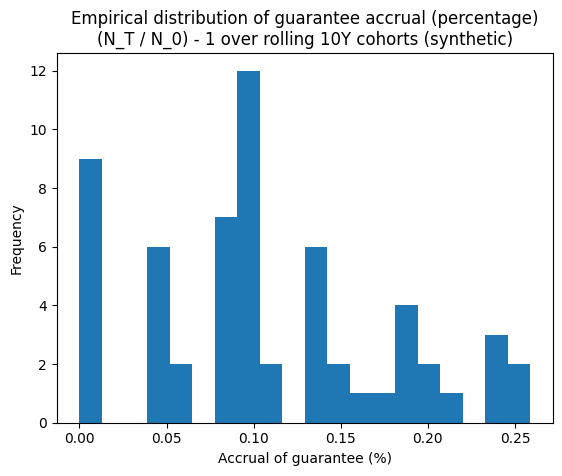

In [ ]:

# Plot the empirical distribution of the accrual of guarantee (percentage)
plt.figure()
plt.hist(summary["accrual_pct"], bins=20)
plt.title("Empirical distribution of guarantee accrual (percentage)\n(N_T / N_0) - 1 over rolling 10Y cohorts (synthetic)")
plt.xlabel("Accrual of guarantee (%)")
plt.ylabel("Frequency")
plt.show()


### How to use with your real data
- Build `active_returns_matrix` with shape `(n_starts, 120)` from your chosen Active series.
- Build `zcb_price_matrix` with shape `(n_starts, 121)` for rolling ZCB prices.
- Then call:
```python
summary, panel = rolling_tie_in_distribution_matrix(active_returns_matrix, zcb_price_matrix)
```
`panel` is a stacked month-by-month matrix across all cohorts (with a `start` column).  
`summary` is one row per cohort with accrual statistics.
